# Module 3 Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

### Exercise 3.1

In [2]:
def nii_to_numpy(nii_file):
    """
    Function to open a NIfTI image file and create an array from it

    Parameters
    - nii_file (str): file path

    Returns
    - image_array (array): the image as an array
    """
    
    image = sitk.ReadImage(nii_file) # Read NIfTI image using SimpleITK
    image_array = sitk.GetArrayFromImage(image)
    
    return image_array

First open files and create arrays, then find the ranges in which the segmentation exists. Finally, create a subvolume by expanding the ranges as instructed in the question paper 

In [3]:
image_collection = []
seg_masks = []
seg_ranges = []

subvolume = []
subvolume_with_mask = []

for i in range(40):

    image = nii_to_numpy("../data/Module3/case_"+str(i)+".nii") # use the nii_to_numpy function to get the scan in array type
    image_collection.append(image)
    mask = nii_to_numpy("../data/Module3/case_"+str(i)+"_mask.nii") # use the nii_to_numpy function to get the mask in array type
    seg_masks.append(mask)
    
    indices = np.where(mask == 1) # these are the indices in x, y, and z where the segmentation exists
    ranges = [(indices[j].min(), indices[j].max()) for j in range(3)] # finding the range (in x, y, and z) where the segmentation exists 
    seg_ranges.append(ranges)
 
    adjustments = [-5, +5, -30, +30, -30, +30] # adjust the ranges by specified amounts to create subvolume of the images
    new_ranges = [(indices[j].min() + adjustments[2 * j], indices[j].max() + adjustments[2 * j + 1]) for j in range(3)] # analogous to definition of ranges

    subvolume.append(image[new_ranges[0][0]:new_ranges[0][1] + 1, 
                           new_ranges[1][0]:new_ranges[1][1] + 1, 
                           new_ranges[2][0]:new_ranges[2][1] + 1]) # get subvolume by slicing the image array in z, y, and x (in that order of indices)
    
    subvolume_with_mask.append(mask[new_ranges[0][0]:new_ranges[0][1] + 1, 
                           new_ranges[1][0]:new_ranges[1][1] + 1, 
                           new_ranges[2][0]:new_ranges[2][1] + 1]) # get mask subvolume by slicing the mask array in z, y, and x (in that order of indices)

Let's define some functions to threshold and segment the image

In [4]:
def get_threshold(image, mask):
    """
    Function to get the minimum and maximum thresholds of the image

    Parameters
    - image (array): the image array
    - mask (array): the segmentation mask

    Returns
    - min_threshold (float): the minimum intensity of voxels within the segmentation
    - max_threshold (float): the maximum intensity of voxels within the segmentation
    """

    masked_voxels = image[mask>0] # get indices where mask is 1, use these to get the corresponding elements (representing intensities) from the image
    
    min_threshold = masked_voxels.min() # find minimum intensity, representing the minimum threshold
    max_threshold = masked_voxels.max() # find maximum intensity, representing the maximum threshold
    
    return min_threshold, max_threshold 

def segment_image(image, min_threshold, max_threshold):
    """
    Function to segment the image

    Parameters
    - image (array): the image that we want to segment
    - min_threshold (float): the minimum threshold intensity
    - max_threshold (float): the maximum threshold intensity

    Returns
    - segmented_image (array): the segmented image
    """

    segmented_image = (image >= min_threshold) & (image <= max_threshold) # keep only elements where the intensities fall within the min and max threshold

    return segmented_image    

Apply the algorithms to the subvolume for each patient and display a comparison between the true segmentation and my segmentation using the thresholding algorithm

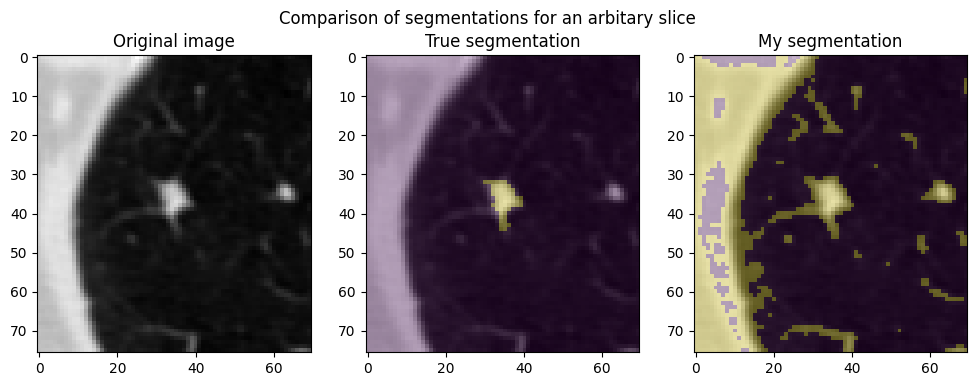

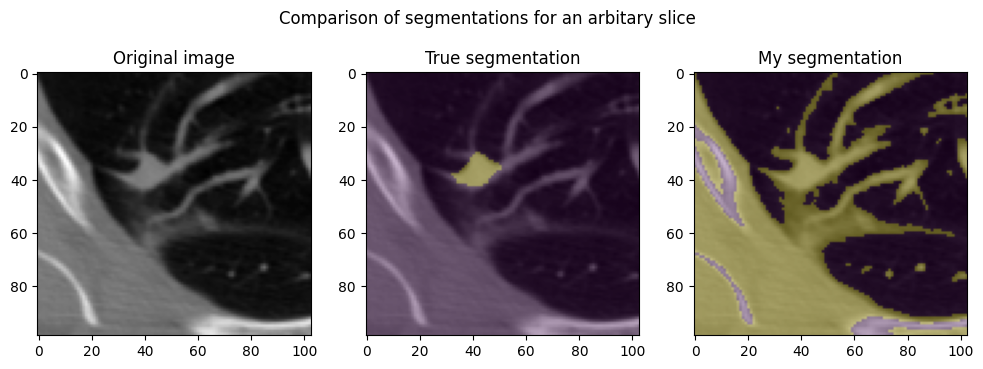

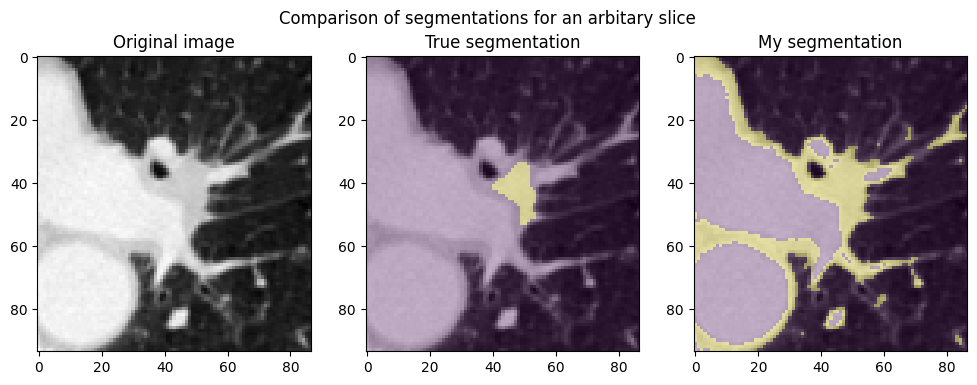

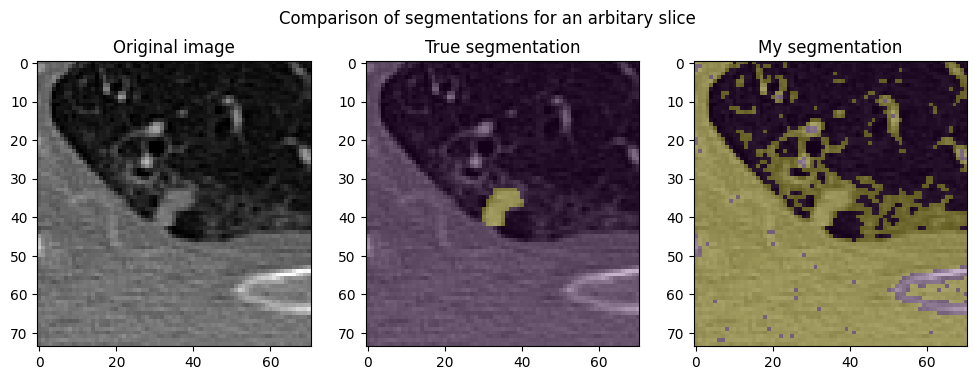

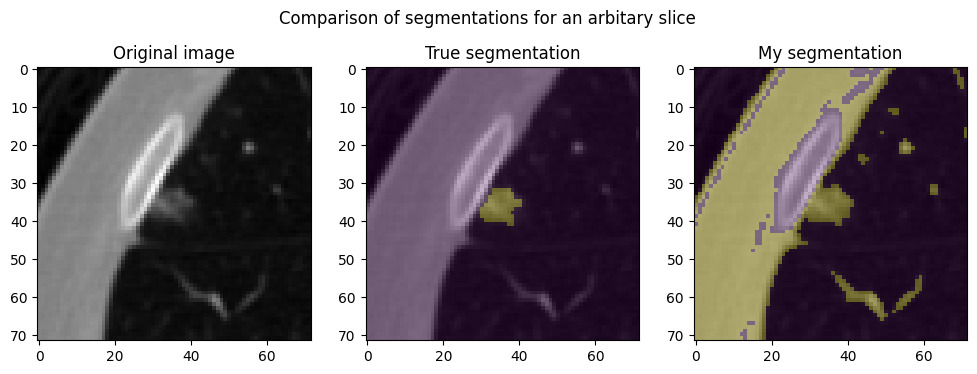

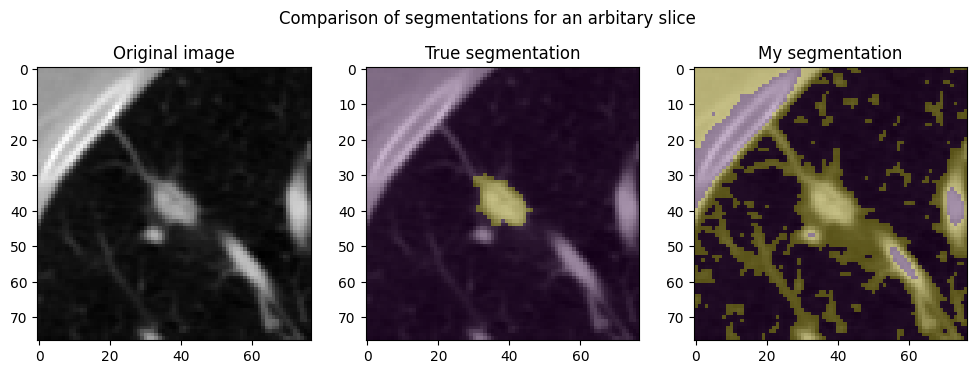

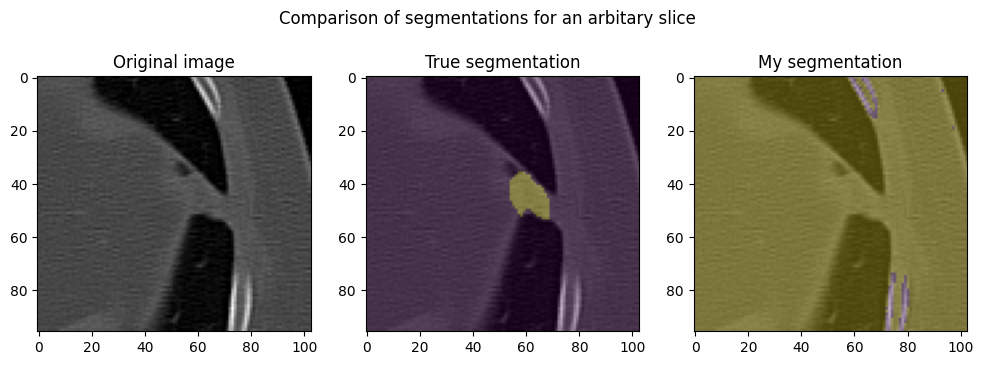

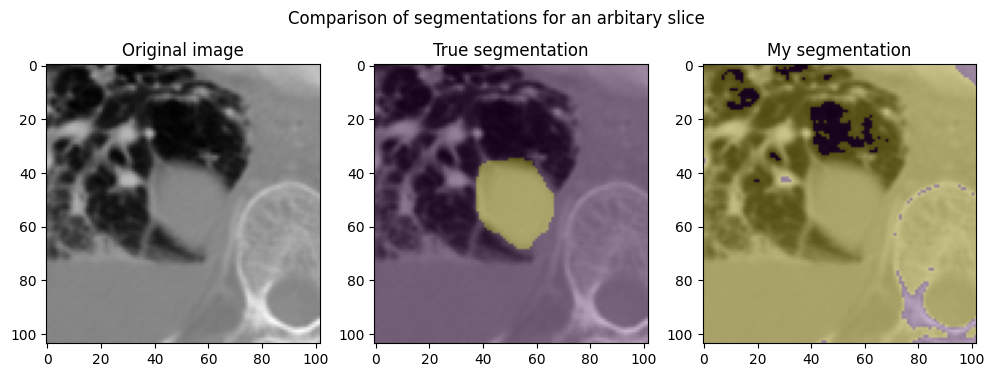

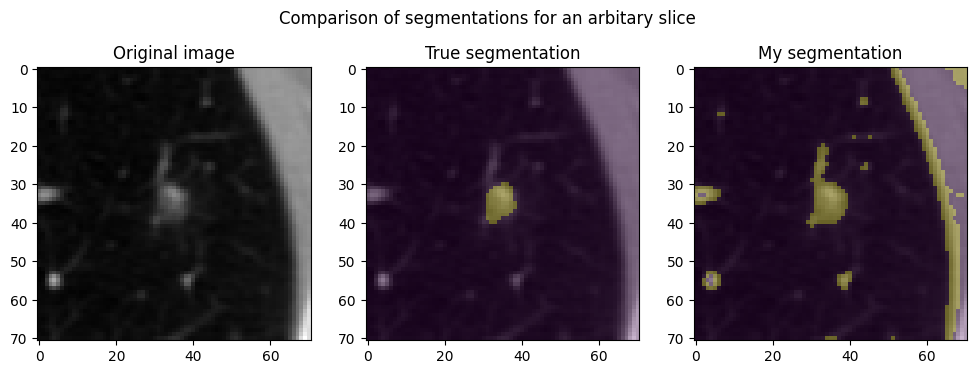

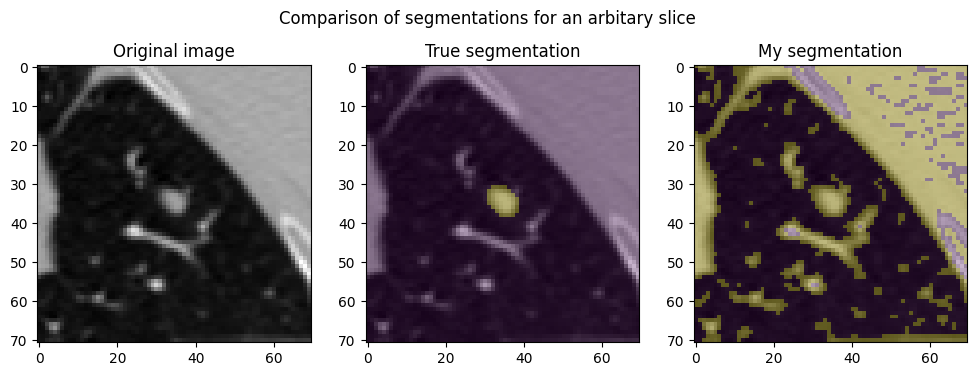

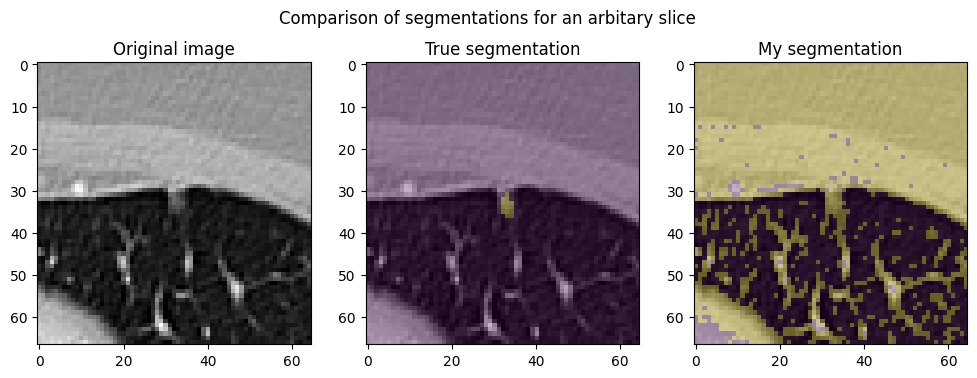

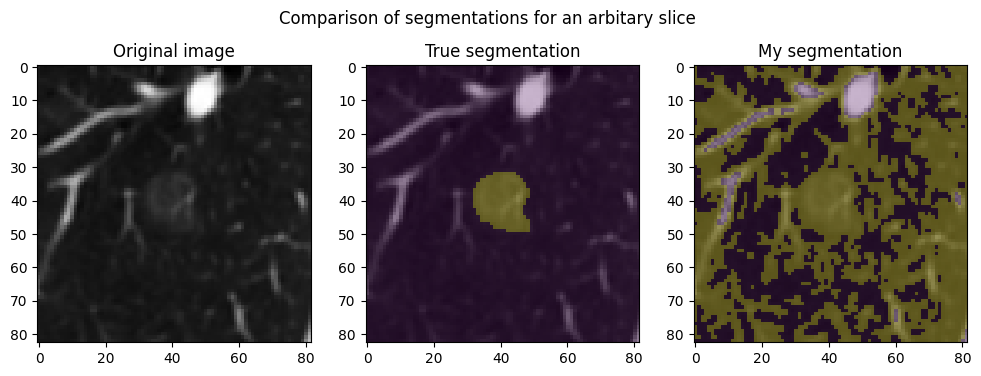

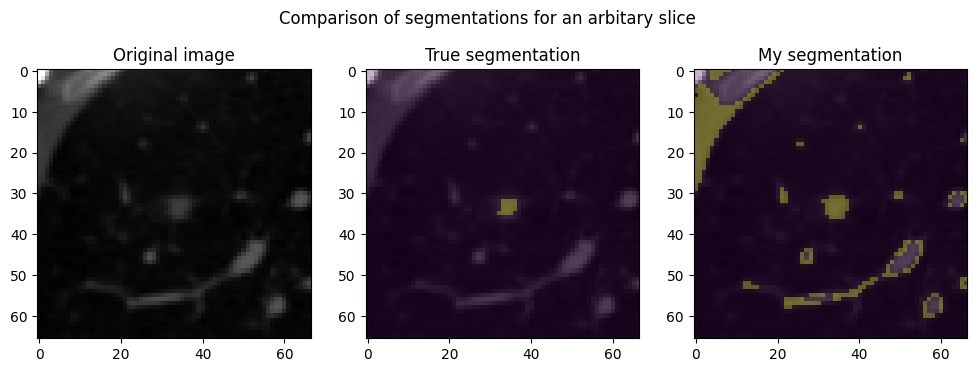

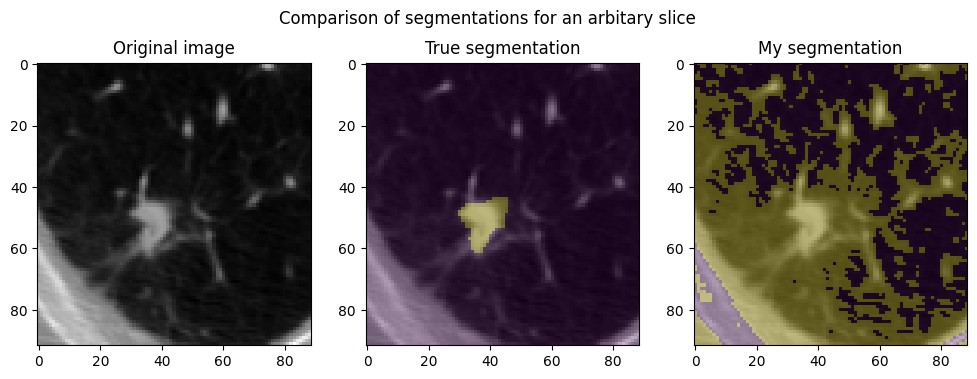

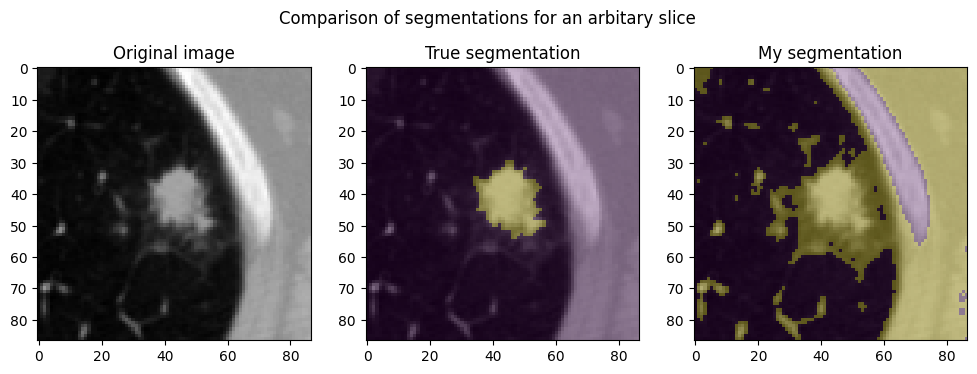

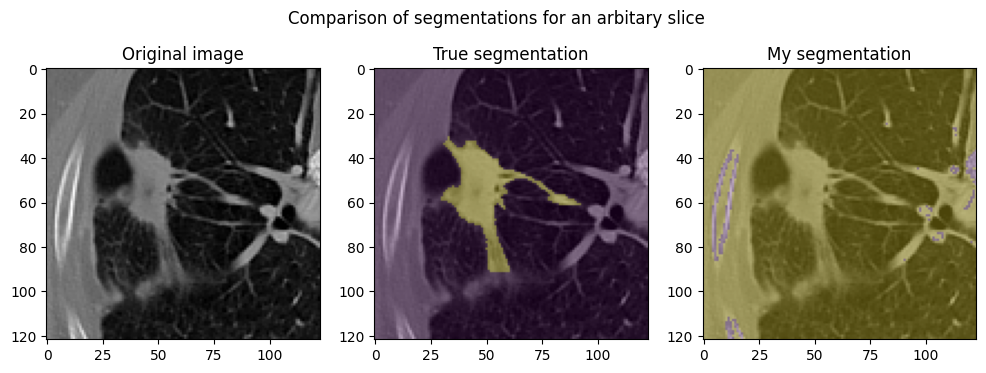

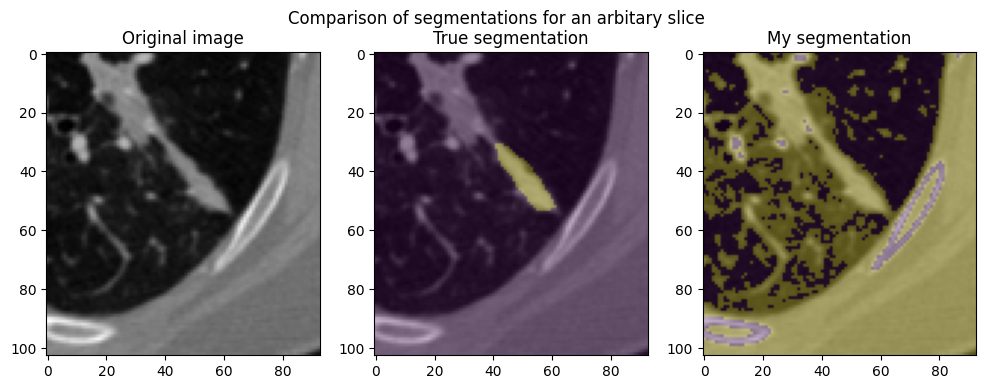

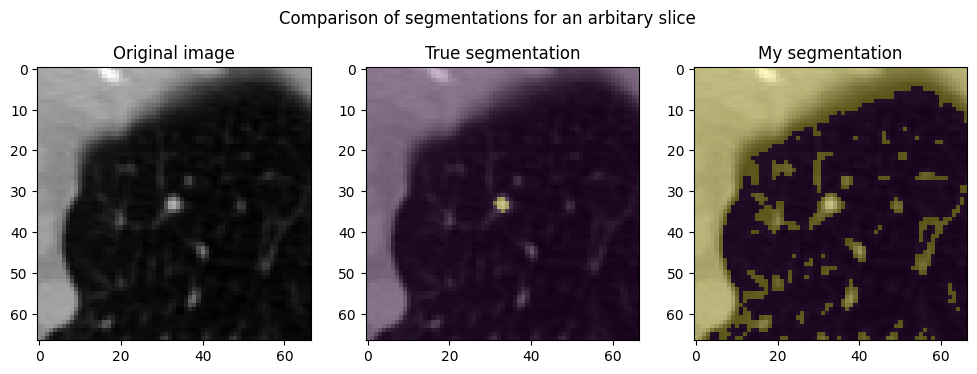

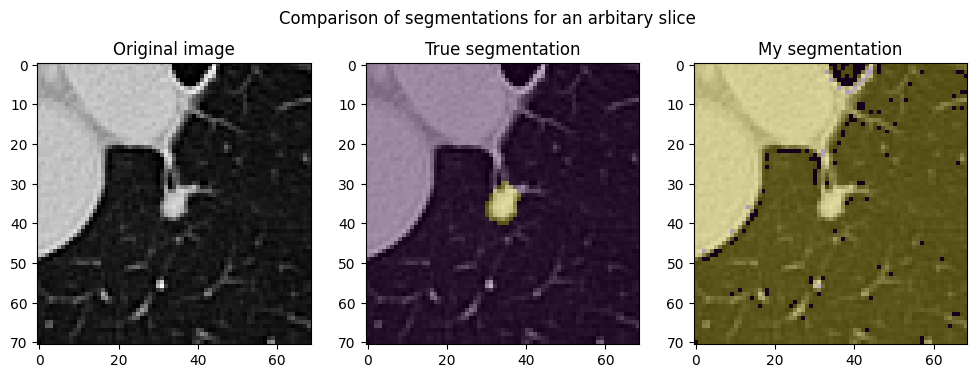

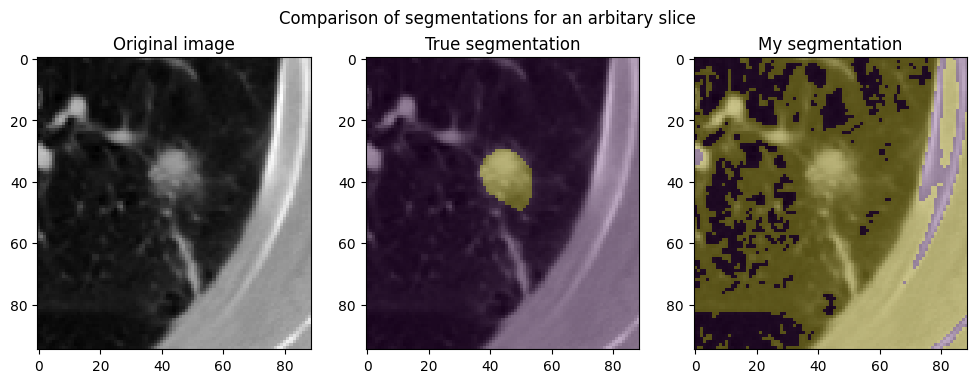

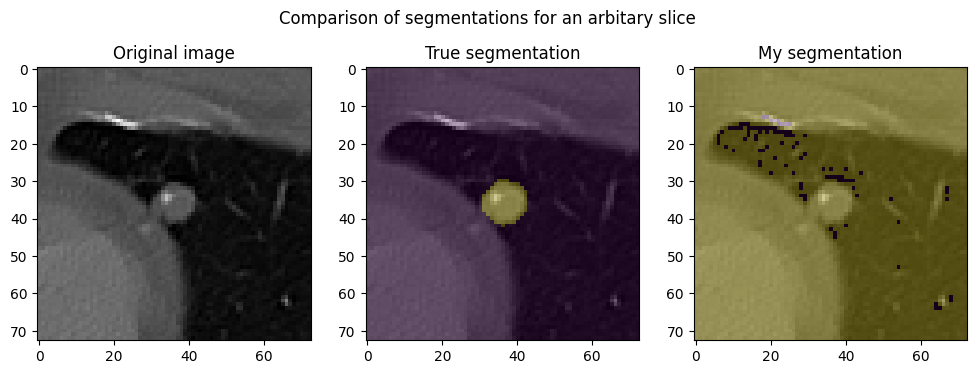

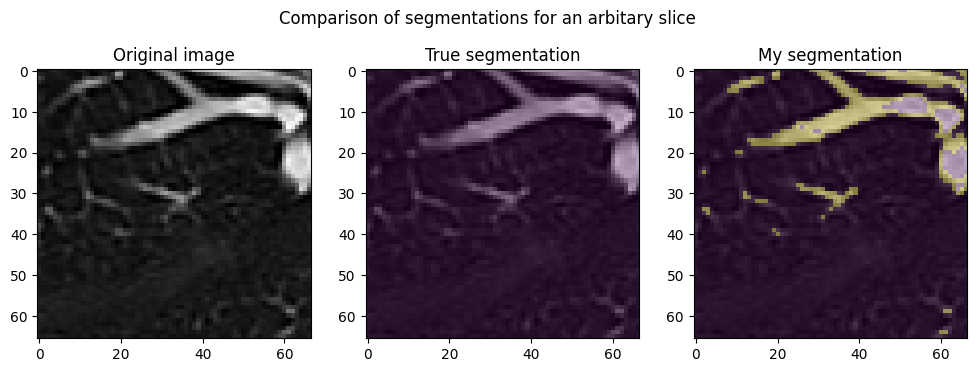

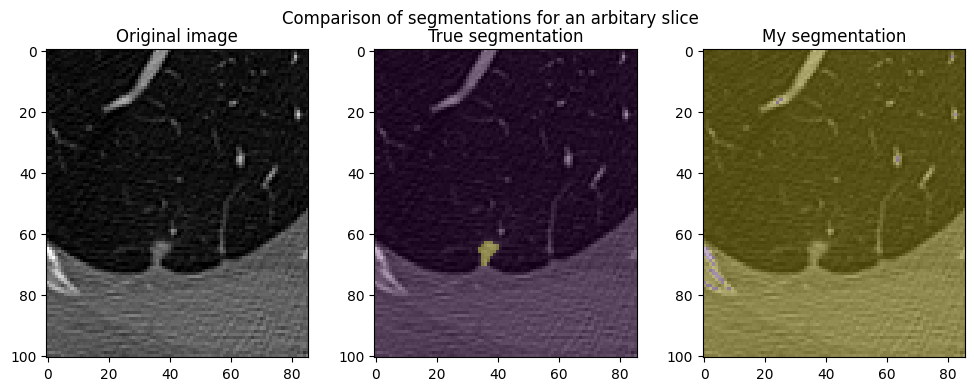

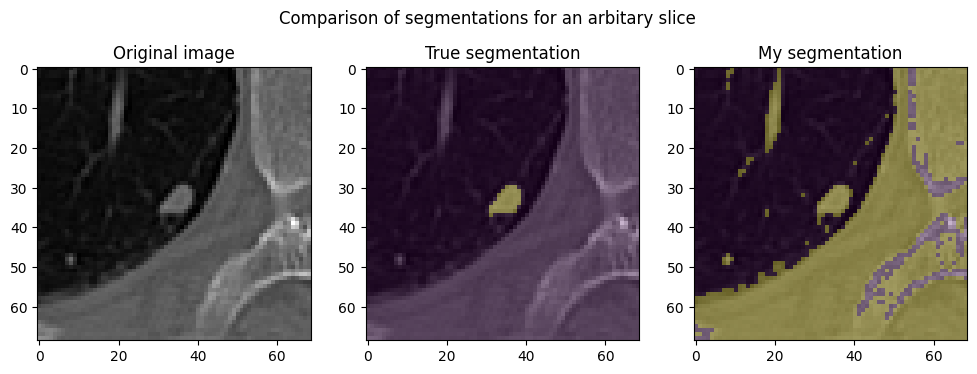

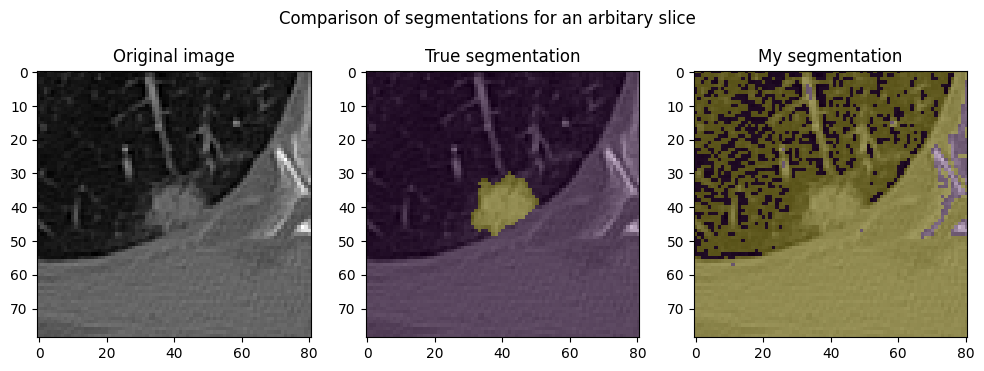

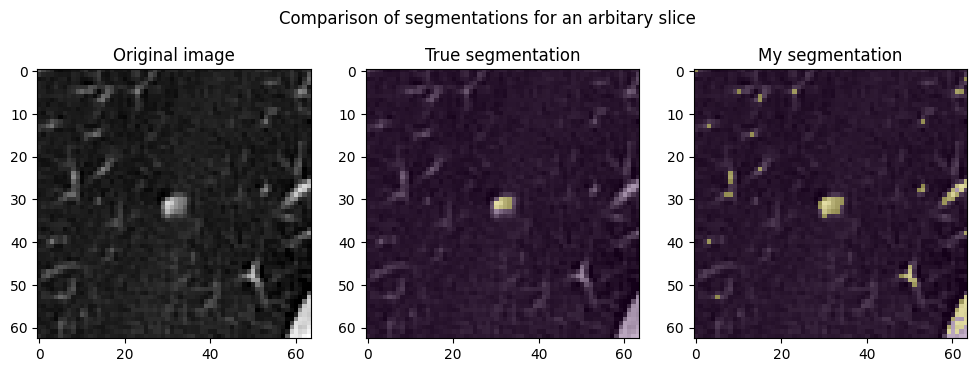

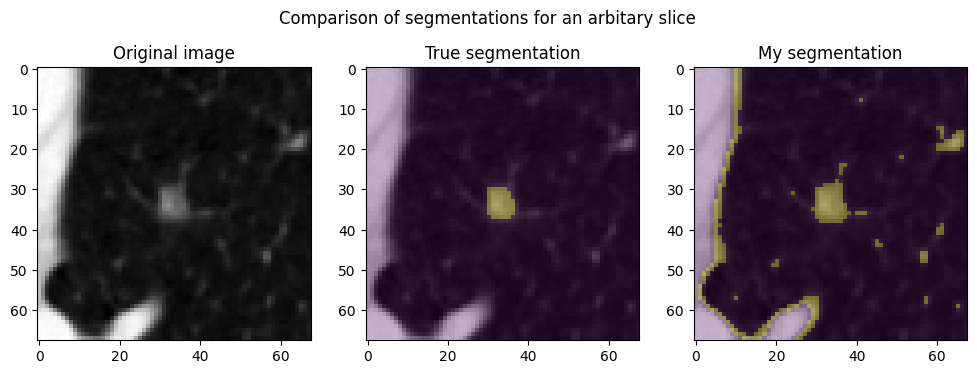

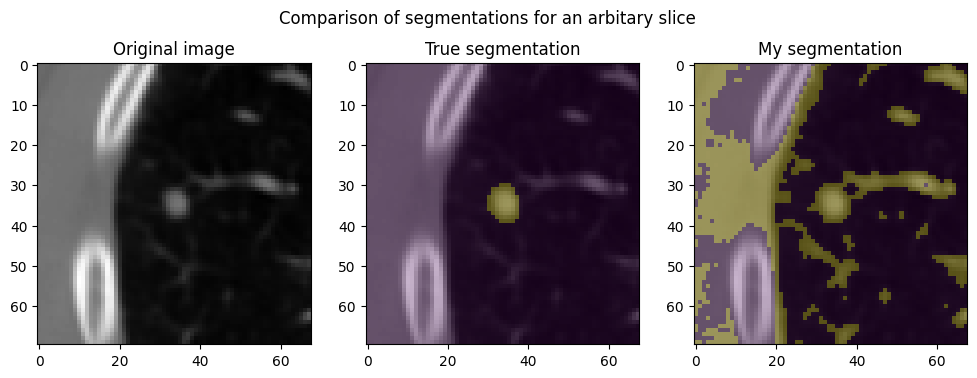

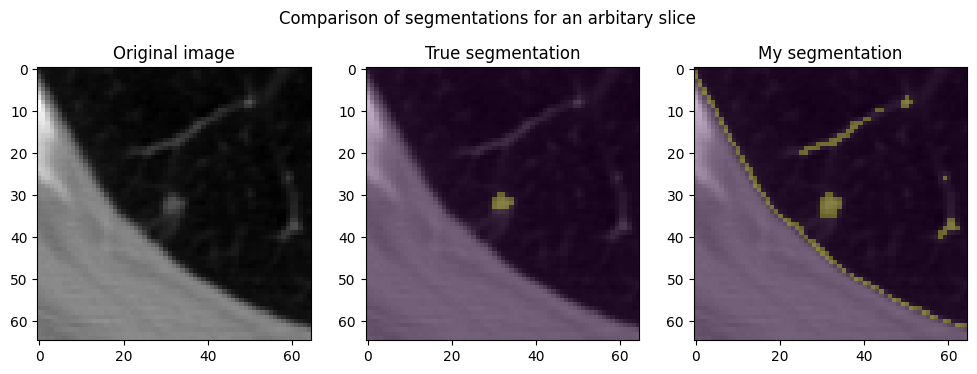

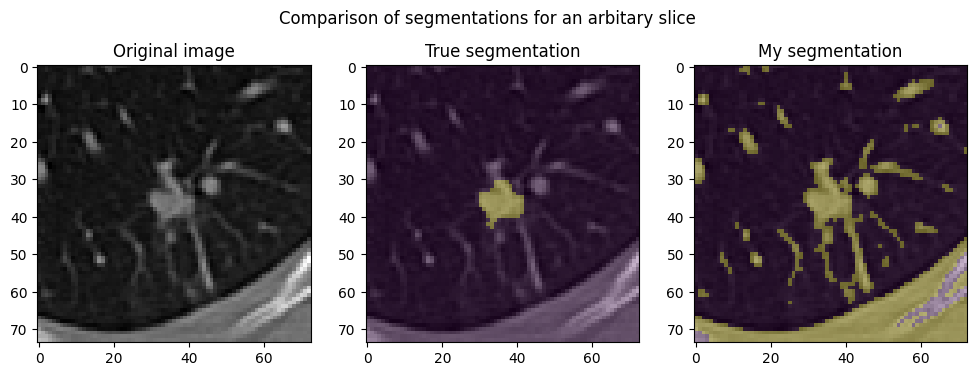

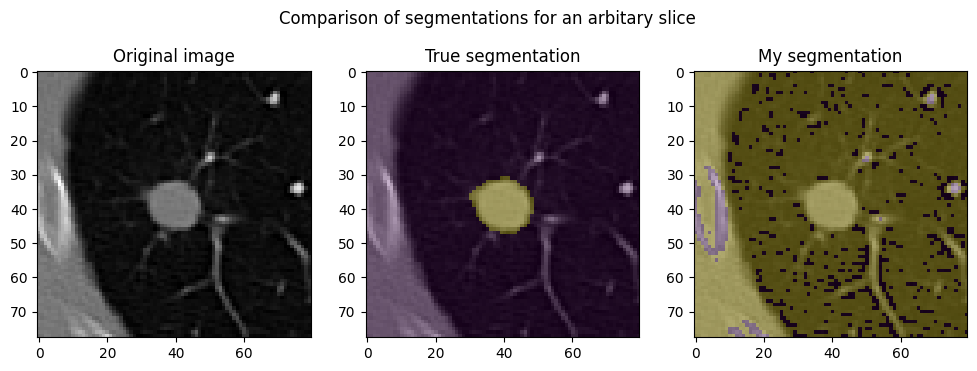

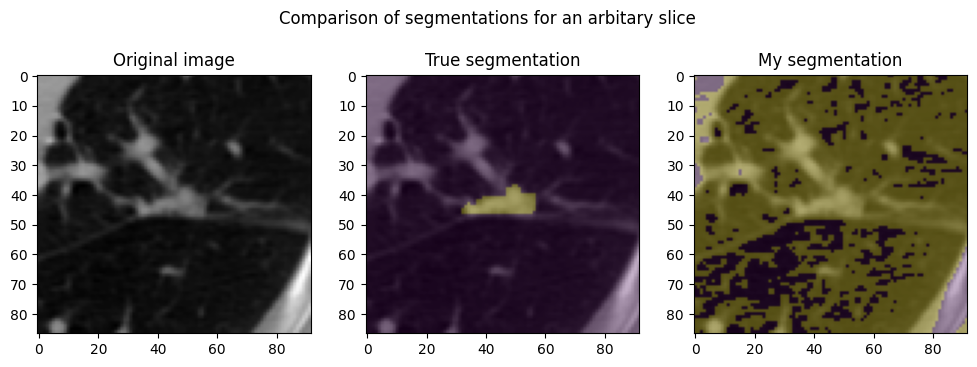

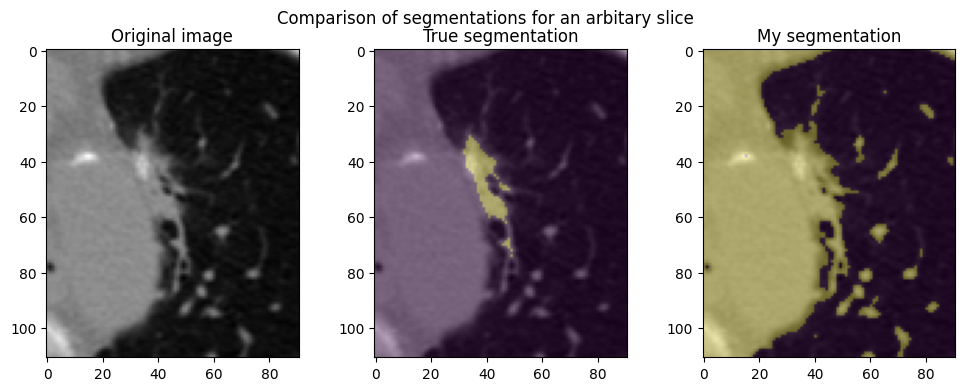

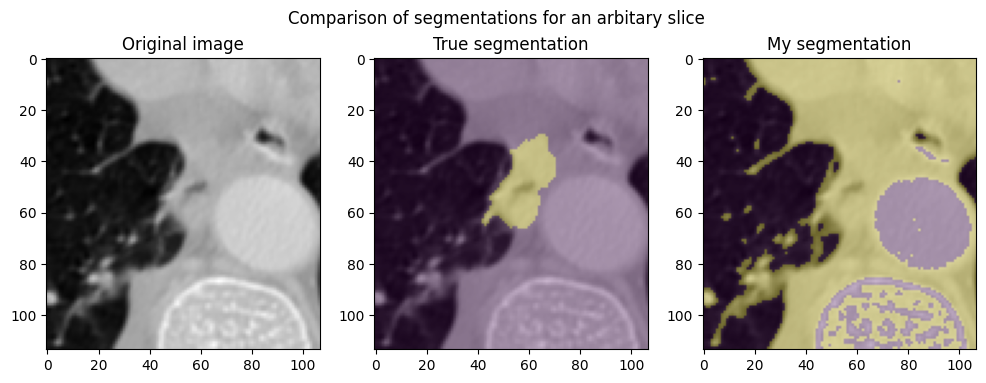

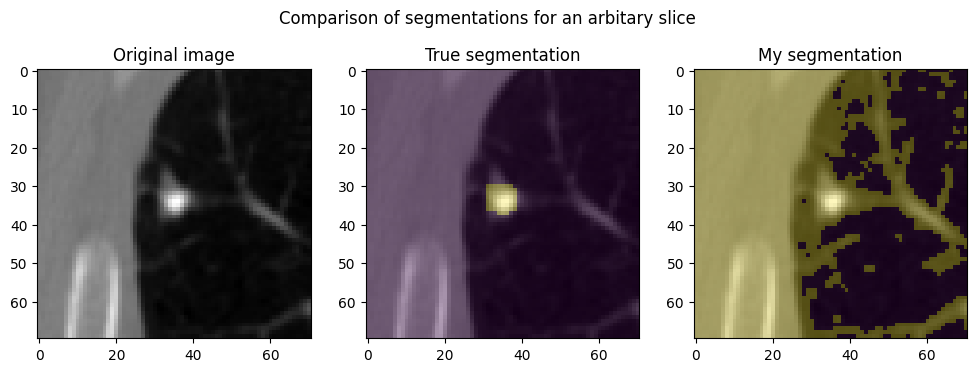

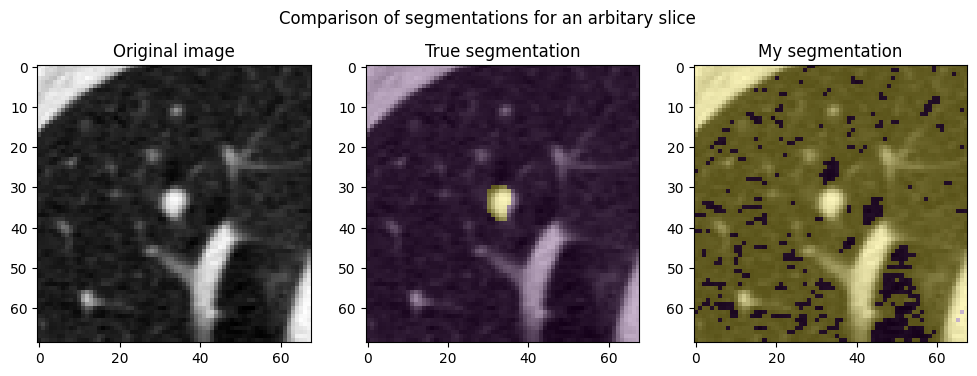

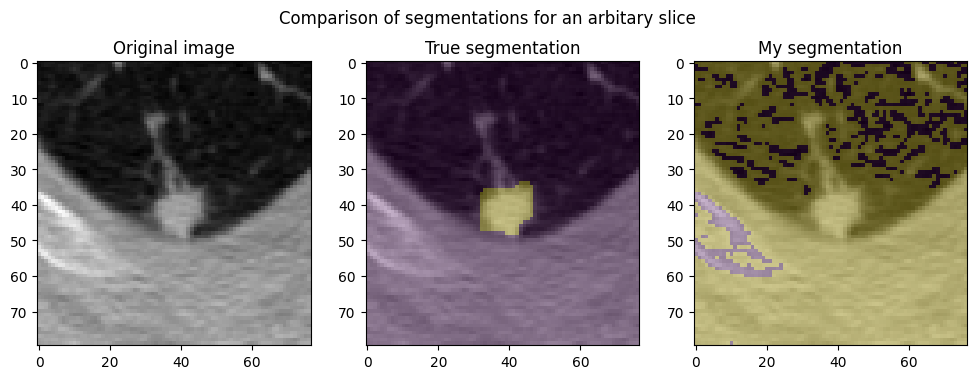

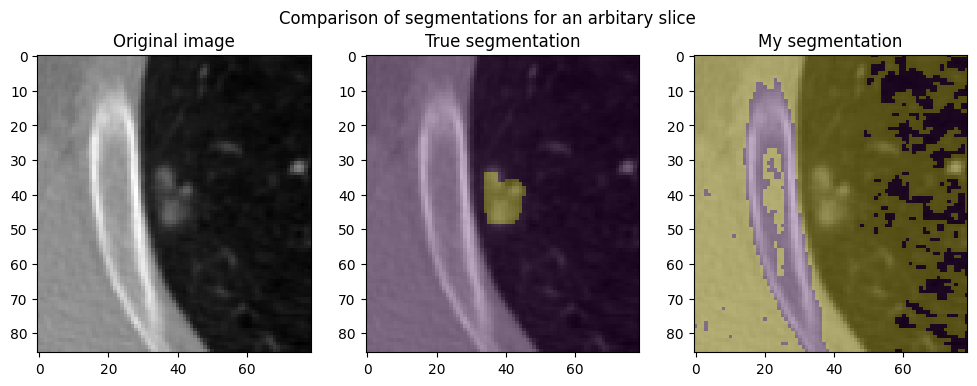

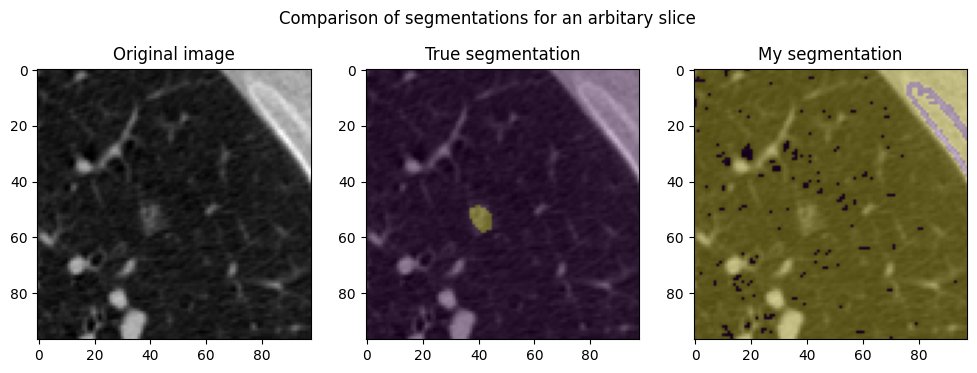

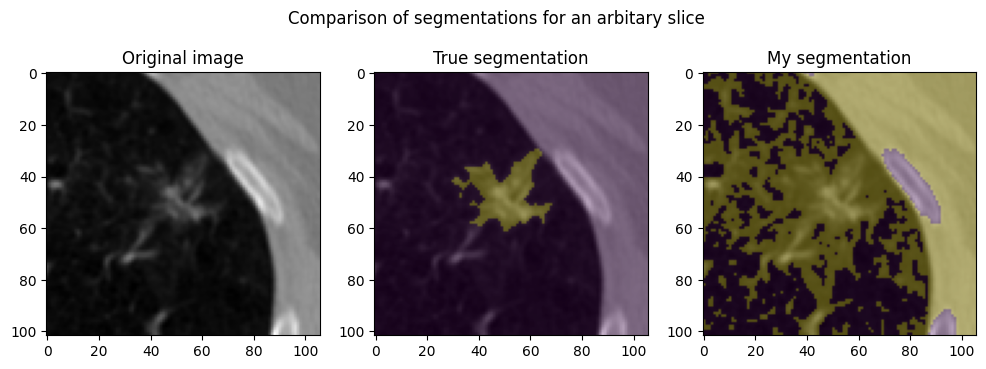

In [5]:
for i in range(40):

    subvol = subvolume[i]
    true_mask = subvolume_with_mask[i]
    
    min_threshold, max_threshold = get_threshold(subvol, true_mask) # get the threshold values from the true segmentation
    img = segment_image(subvol, min_threshold, max_threshold) # use the threshold values to segment the subvolume

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(subvol[6], cmap='gray')
    axes[0].set_title("Original image")

    axes[1].imshow(subvol[6], cmap='gray')
    axes[1].imshow(true_mask[6], cmap='viridis', alpha=0.3)
    axes[1].set_title("True segmentation")

    axes[2].imshow(subvol[6], cmap='gray')
    axes[2].imshow(img[6], cmap='viridis', alpha=0.3)
    axes[2].set_title("My segmentation")
    
    plt.suptitle("Comparison of segmentations for an arbitary slice")

    plt.show()


### Exercise 3.2

In [6]:
import pandas as pd # to read and save .csv data

Let's define the necessary functions

In [7]:
def calc_V(image, mask):
    """
    Function to return the set of intensities of the voxels in the segmentation

    Parameters
    image (array): the subvolume
    mask (array): the true segmentation mask

    Returns
    v (array): the set of intensities
    """

    v = image[mask>0] # get indices where mask is 1, use these to get the corresponding elements (representing intensities) from the image
    
    return v

def calc_energy(V):
    """
    Function to calculate the value of the Energy feature 

    Parameters
    V (array): the set of intensities

    Returns
    energy (float): the energy
    """
    energy = np.sum(np.square(V))

    return energy

def calc_mad(V, N):
    """
    Function to calculate the value of the Mean Absolute Difference (MAD) feature 

    Parameters
    V (array): the set of intensities
    N (int): the number of voxels in the segmentation

    Returns
    mad (float): the MAD value
    """
    V_bar = np.average(V)

    mad = (1/N) * np.sum(np.abs(V - V_bar))

    return mad

def calc_uniformity(P, N):
    """
    Function to calculate the value of the Uniformity feature 

    Parameters
    P (array): the number of entries in each histogram bin
    N (int): the number of voxels in the segmentation

    Returns
    uniformity (float): the Uniformity value
    """
    p = P/N
    uniformity = np.sum(p**2)

    return uniformity

Calculate the value of the radiomic features defined above for all patients

In [8]:
M = 100 # arbitrary value that strikes a balance between too narrow and too wide bins

Energy = []
Mad = []
Uniformity = []

for i in range(40):

    v = calc_V(subvolume[i], subvolume_with_mask[i])
    v = v.astype(np.float64) # change datatype from int16 to float64 for sufficient precision
    n = len(v)
    e = calc_energy(v)
    mad = calc_mad(v, n)

    hist, bin_edges = np.histogram(v, bins = M, range = (v.min(), v.max()), density=False)
    u = calc_uniformity(hist, n)

    Energy.append(e)
    Mad.append(mad)
    Uniformity.append(u)


Energy = np.array(Energy, dtype=int) 
Mad = np.array(Mad, dtype=np.float64)
Uniformity = np.array(Uniformity, dtype=np.float64)

df_diagnosis = pd.read_csv("../data/Module3/labels.csv")
diagnosis_list = df_diagnosis["Diagnosis"].tolist()
df = pd.DataFrame({"Energy": Energy, "Mean Absolute Deviation (MAD)": Mad, "Uniformity": Uniformity, "Clinical label":diagnosis_list})
df.to_csv("../output/radiomic_features.csv") # save to file for reference
print(df)

        Energy  Mean Absolute Deviation (MAD)  Uniformity  Clinical label
0     27673733                     189.503849    0.018996               2
1     57513797                     106.039925    0.037137               3
2     10559604                      30.289575    0.052769               2
3     13421304                     197.117147    0.017554               1
4    110762266                     122.899089    0.015999               3
5     81139875                     203.623394    0.013140               1
6    338651050                     220.788669    0.024592               2
7    131749294                      56.717060    0.184602               2
8     24864639                     105.551653    0.020087               1
9     50534100                     235.489366    0.014248               1
10     6673689                     274.027778    0.040123               1
11   965718972                      47.669994    0.025210               3
12     2368756                     118

Let's plot a histogram of the features and see if benign and malignant tumours appear well separated

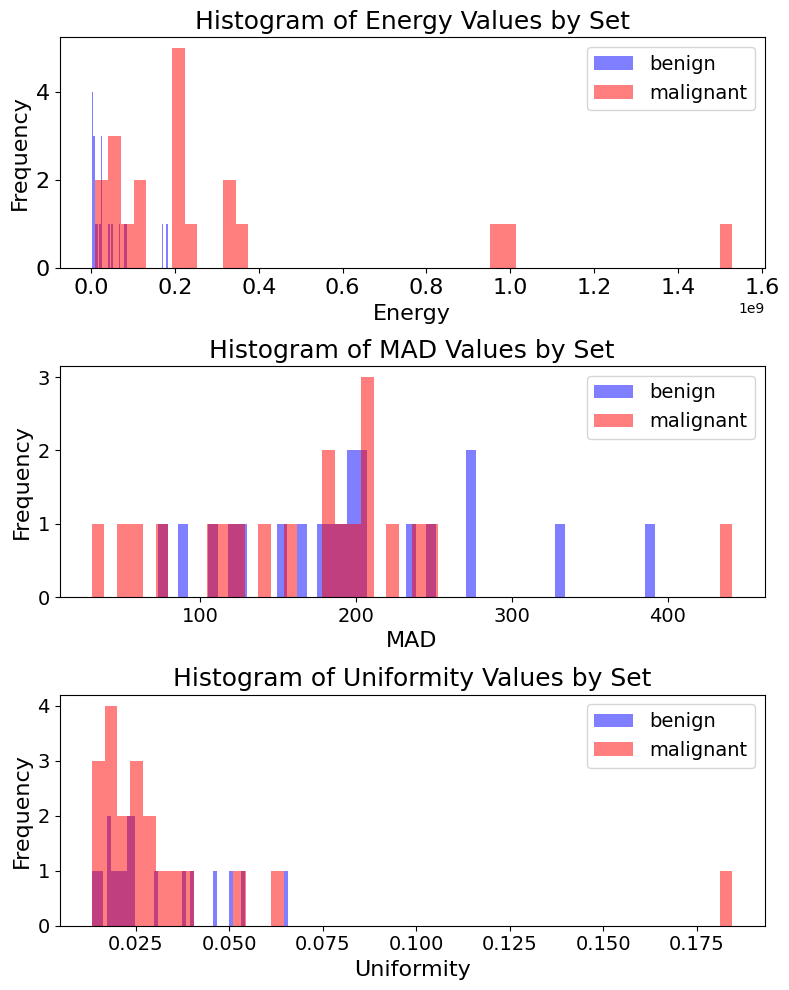

In [9]:
diagnosis_array = np.array(diagnosis_list)
diagnosis_array[diagnosis_array == 3] = 2 # labels 2 and 3 correspond to malignant tumours, so combine these labels 

colors = {1: 'blue', 2: 'red'}
set_label_mapping = {1: 'benign', 2: 'malignant'}

fig, axes = plt.subplots(3, 1, figsize=(8, 10))

for set_id in np.unique(diagnosis_array):
    label = set_label_mapping[set_id]
    axes[0].hist(Energy[diagnosis_array == set_id], bins=50, alpha=0.5, label=label, color=colors[set_id])
    axes[1].hist(Mad[diagnosis_array == set_id], bins=50, alpha=0.5, label=label, color=colors[set_id])
    axes[2].hist(Uniformity[diagnosis_array == set_id], bins=50, alpha=0.5, label=label, color=colors[set_id])

axes[0].set_xlabel('Energy', fontsize=16)
axes[0].set_ylabel('Frequency', fontsize=16)
axes[0].set_title('Histogram of Energy Values by Set', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[0].legend(fontsize=14)

axes[1].set_xlabel('MAD', fontsize=16)
axes[1].set_ylabel('Frequency', fontsize=16)
axes[1].set_title('Histogram of MAD Values by Set', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].legend(fontsize=14)

axes[2].set_xlabel('Uniformity', fontsize=16)
axes[2].set_ylabel('Frequency', fontsize=16)
axes[2].set_title('Histogram of Uniformity Values by Set', fontsize=18)
axes[2].tick_params(axis='both', which='major', labelsize=14)
axes[2].legend(fontsize=14)
plt.tight_layout()
plt.show()

Let's plot a box-plot for each feature and see if the distribution of values for benign and malignant tumours appear different 

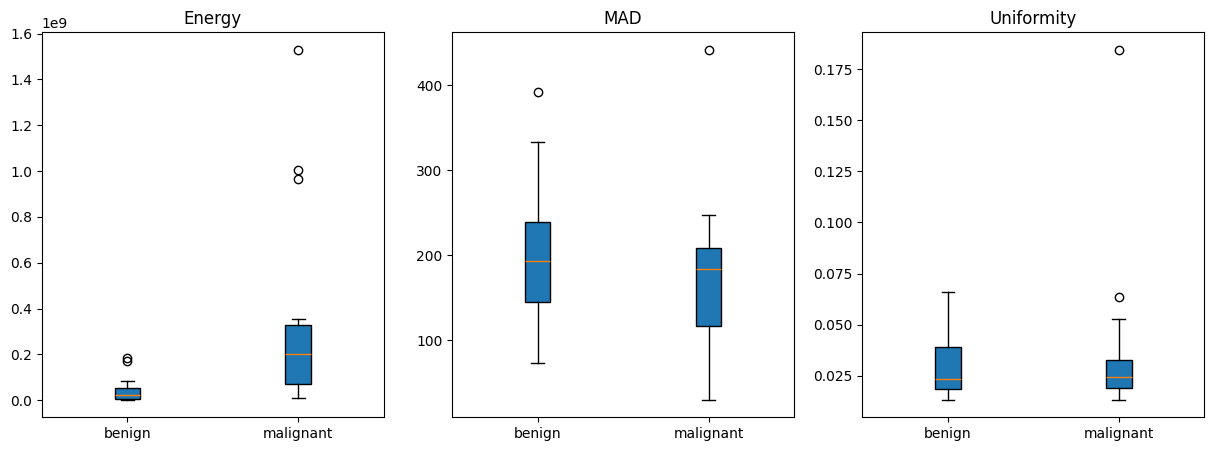

In [10]:
benign_energy = Energy[diagnosis_array == 1]
malignant_energy = Energy[diagnosis_array == 2]

benign_mad = Mad[diagnosis_array == 1]
malignant_mad = Mad[diagnosis_array == 2]

benign_uni = Uniformity[diagnosis_array == 1]
malignant_uni = Uniformity[diagnosis_array == 2]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].boxplot([benign_energy, malignant_energy], tick_labels=['benign', 'malignant'], patch_artist=True)
axes[0].set_title("Energy")

axes[1].boxplot([benign_mad, malignant_mad], tick_labels=['benign', 'malignant'], patch_artist=True)
axes[1].set_title("MAD")

axes[2].boxplot([benign_uni, malignant_uni], tick_labels=['benign', 'malignant'], patch_artist=True)
axes[2].set_title("Uniformity")

plt.show()